
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [38]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_fake
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, hidden_size=hidden_size)

    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size, 
                                reuse=True)
    print('Qs.shape, nextQs.shape, nextQs_fake.shape, nextQs_real.shape:',
          Qs.shape, nextQs.shape, nextQs_fake.shape, nextQs_real.shape)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
#     g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
#                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_real #+ g_loss_fake2

    # Discriminator loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                         labels=tf.zeros_like(nextQs)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.nn.sigmoid(nextQs)))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [39]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [40]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [41]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [42]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [43]:
train_episodes = 500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [44]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

Qs.shape, nextQs.shape, nextQs_fake.shape, nextQs_real.shape: (?, 1) (?, 1) (?, 1) (?, 1)


## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [45]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3 Training g_loss: 1.4649 Training d_loss: 1.3802 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10 Training g_loss: 1.2875 Training d_loss: 1.2723 Explore P: 0.9987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 10 Training g_loss: 1.2153 Training d_loss: 1.1417 Explore P: 0.9977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 12 Training g_loss: 1.2305 Training d_loss: 1.0288 Explore P: 0.9965
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 34 Total reward: 31 Training g_loss: 3.2259 Training d_loss: 0.2299 Explore P: 0.9309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 16 Training g_loss: 2.5863 Training d_loss: 0.3658 Explore P: 0.9295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 8 Training g_loss: 2.7080 Training d_loss: 0.3567 Explore P: 0.9287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 143 Training g_loss: 3.2162 Training d_loss: 0.2296 Explore P: 0.9157
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 67 Total reward: 25 Training g_loss: 4.4822 Training d_loss: 0.1442 Explore P: 0.8406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 33 Training g_loss: 3.9602 Training d_loss: 0.1689 Explore P: 0.8378
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 20 Training g_loss: 4.8939 Training d_loss: 0.1177 Explore P: 0.8362
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 14 Training g_loss: 4.4154 Training d_loss: 0.1547 Explore P: 0.8350
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 100 Total reward: 30 Training g_loss: 5.5574 Training d_loss: 0.0900 Explore P: 0.7552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 51 Training g_loss: 5.6582 Training d_loss: 0.0943 Explore P: 0.7514
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 65 Training g_loss: 6.2180 Training d_loss: 0.0637 Explore P: 0.7466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 37 Training g_loss: 5.0482 Training d_loss: 0.1416 Explore P: 0.7439
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 111 Training g_loss: 6.6749 Training d_loss: 0.0905 Explore P: 0.6581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 48 Training g_loss: 6.2550 Training d_loss: 0.1080 Explore P: 0.6550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 29 Training g_loss: 7.0912 Training d_loss: 0.0647 Explore P: 0.6532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 33 Training g_loss: 6.6772 Training d_loss: 0.0972 Explore P: 0.6510
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 164 Total reward: 26 Training g_loss: 6.9855 Training d_loss: 0.0655 Explore P: 0.5236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 172 Training g_loss: 6.8784 Training d_loss: 0.0757 Explore P: 0.5149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 158 Training g_loss: 6.8951 Training d_loss: 0.0718 Explore P: 0.5070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 81 Training g_loss: 7.3280 Training d_loss: 0.0818 Explore P: 0.5029
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 196 Total reward: 140 Training g_loss: 6.6483 Training d_loss: 0.0790 Explore P: 0.3558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 197 Total reward: 194 Training g_loss: 6.4179 Training d_loss: 0.0918 Explore P: 0.3492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 198 Total reward: 57 Training g_loss: 6.0453 Training d_loss: 0.0735 Explore P: 0.3473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 199 Total reward: 170 Training g_loss: 6.4476 Training d_loss: 0.0720 Explore P: 0.3416
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 228 Total reward: 199 Training g_loss: 5.9312 Training d_loss: 0.1170 Explore P: 0.2061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 199 Training g_loss: 5.6076 Training d_loss: 0.1261 Explore P: 0.2022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 230 Total reward: 187 Training g_loss: 3.9427 Training d_loss: 0.1833 Explore P: 0.1986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 192 Training g_loss: 5.1401 Training d_loss: 0.1640 Explore P: 0.1950
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 260 Total reward: 199 Training g_loss: 3.2279 Training d_loss: 0.2347 Explore P: 0.1159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 261 Total reward: 108 Training g_loss: 2.7900 Training d_loss: 0.2297 Explore P: 0.1148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 262 Total reward: 199 Training g_loss: 5.8751 Training d_loss: 0.1216 Explore P: 0.1127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 263 Total reward: 199 Training g_loss: 4.5127 Training d_loss: 0.1489 Explore P: 0.1107
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 292 Total reward: 199 Training g_loss: 4.3396 Training d_loss: 0.1443 Explore P: 0.0665
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 199 Training g_loss: 3.6255 Training d_loss: 0.1949 Explore P: 0.0654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 294 Total reward: 199 Training g_loss: 4.1352 Training d_loss: 0.1444 Explore P: 0.0643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 199 Training g_loss: 3.8549 Training d_loss: 0.1547 Explore P: 0.0633
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 324 Total reward: 199 Training g_loss: 3.8401 Training d_loss: 0.1988 Explore P: 0.0403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 179 Training g_loss: 3.9766 Training d_loss: 0.1811 Explore P: 0.0397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 199 Training g_loss: 4.5574 Training d_loss: 0.1588 Explore P: 0.0392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 199 Training g_loss: 4.0347 Training d_loss: 0.1637 Explore P: 0.0386
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 356 Total reward: 199 Training g_loss: 3.8776 Training d_loss: 0.1505 Explore P: 0.0264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 357 Total reward: 137 Training g_loss: 4.0128 Training d_loss: 0.1499 Explore P: 0.0262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 358 Total reward: 199 Training g_loss: 3.8144 Training d_loss: 0.1610 Explore P: 0.0259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 359 Total reward: 199 Training g_loss: 3.3642 Training d_loss: 0.2403 Explore P: 0.0256
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 388 Total reward: 199 Training g_loss: 2.2819 Training d_loss: 0.4125 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 389 Total reward: 199 Training g_loss: 2.7651 Training d_loss: 0.3117 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 390 Total reward: 199 Training g_loss: 2.3693 Training d_loss: 0.3626 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 391 Total reward: 199 Training g_loss: 2.8236 Training d_loss: 0.2874 Explore P: 0.0182
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 420 Total reward: 199 Training g_loss: 2.9278 Training d_loss: 0.2664 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 421 Total reward: 151 Training g_loss: 3.1399 Training d_loss: 0.2589 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 422 Total reward: 199 Training g_loss: 2.9675 Training d_loss: 0.2891 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 423 Total reward: 199 Training g_loss: 2.8070 Training d_loss: 0.3146 Explore P: 0.0144
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 452 Total reward: 199 Training g_loss: 3.5126 Training d_loss: 0.1582 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 453 Total reward: 199 Training g_loss: 3.6724 Training d_loss: 0.1414 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 454 Total reward: 199 Training g_loss: 3.0752 Training d_loss: 0.2654 Explore P: 0.0124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 455 Total reward: 199 Training g_loss: 2.4879 Training d_loss: 0.3769 Explore P: 0.0123
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 484 Total reward: 199 Training g_loss: 3.2329 Training d_loss: 0.2359 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 198 Training g_loss: 3.3892 Training d_loss: 0.1969 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 199 Training g_loss: 2.8005 Training d_loss: 0.2997 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 199 Training g_loss: 3.1166 Training d_loss: 0.2573 Explore P: 0.0113
----------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

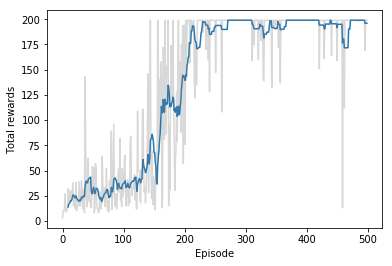

In [48]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

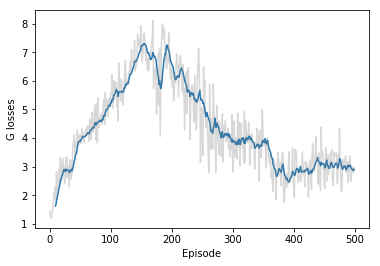

In [49]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

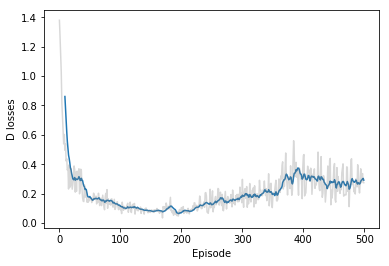

In [50]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.